In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

In [2]:
def random_sin(a: float, f: float, p: float, start: float, end: float, n: int, noise: float = 0.1, irregular: bool = False):
    """Genera una señal sinusoidal aleatoria con ruido.

    Args:
        a (float): amplitud
        f (float): Frecuencia (Hz)
        p (float): Fase
        start (float): Tiempo de inicio
        end (float): Tiempo de termino
        n (int): numero de muestras
        noise (float, optional): Varianza del ruido. Defaults to 0.1.
        irregular (bool, optional): Si es True, se generan muestras irregulares. Defaults to False.
    """
    if irregular:
        t = np.sort(np.random.uniform(start, end, n))
    else:
        t = np.linspace(start, end, n)
    y = a * np.sin(2 * np.pi * f * t + p) + np.random.normal(0, noise, n)
    return t, y, 1/f
    

In [3]:
def random_triangular(a: float, f: float, p: float, start: float, end: float, n: int, noise: float = 0.05, irregular: bool = False):
    """Genera una señal triangular aleatoria con ruido.

    Args:
        a (float): amplitud
        f (float): Frecuencia (Hz)
        p (float): Fase
        start (float): Tiempo de inicio
        end (float): Tiempo de termino
        n (int): numero de muestras
        noise (float, optional): Varianza del ruido. Defaults to 0.1.
        irregulat(bool, optional): Si es True, se generan muestras irregulares. Defaults to False.
    """
    if irregular:
        t = np.sort(np.random.uniform(start, end, n))
    else:
        t = np.linspace(start, end, n)
    y = 4*a*f*np.abs(np.mod(t-1/(4*f)+p, 1/f)-1/(2*f)) - a + np.random.normal(0, noise, n)
    return t, y, 1/f

In [4]:
def random_square(a: float, f: float, p: float, start: float, end: float, n: int, noise: float = 0.02, irregular: bool = False):
    """Genera una señal cuadrada aleatoria con ruido.

    Args:
        a (float): amplitud
        f (float): Frecuencia (Hz)
        p (float): Fase
        start (float): Tiempo de inicio
        end (float): Tiempo de termino
        n (int): numero de muestras
        noise (float, optional): Varianza del ruido. Defaults to 0.1.
        irregular (bool, optional): Si es True, se generan muestras irregulares. Defaults to False.
    """
    if irregular:
        t = np.sort(np.random.uniform(start, end, n))
    else:
        t = np.linspace(start, end, n)
    y = a * np.sign(np.sin(2 * np.pi * f * t + p)) + np.random.normal(0, noise, n)
    return t, y, 1/f

In [5]:
def random_sawtooth(a: float, f: float, p: float, start: float, end: float, n: int, noise: float = 0.02, irregular: bool = False):
    """Genera una señal triangular aleatoria con ruido.

    Args:
        a (float): amplitud
        f (float): Frecuencia (Hz)
        p (float): Fase
        start (float): Tiempo de inicio
        end (float): Tiempo de termino
        n (int): numero de muestras
        noise (float, optional): Varianza del ruido. Defaults to 0.1.
        irregular (bool, optional): Si es True, se generan muestras irregulares. Defaults to False.
    """
    if irregular:
        t = np.sort(np.random.uniform(start, end, n))
    else:
        t = np.linspace(start, end, n)
    y = 2*a*(t*f-np.floor(1/2+t*f)) + np.random.normal(0, noise, n)
    return t, y, 1/f

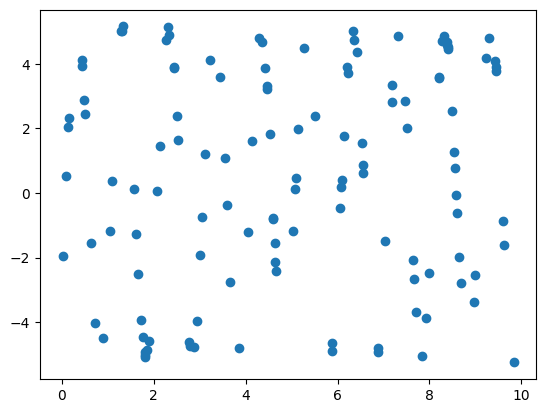

In [6]:
t, y, p= random_sin(5, 1, -0.5, 0, 10, 120,irregular=True)
plt.scatter(t, y)

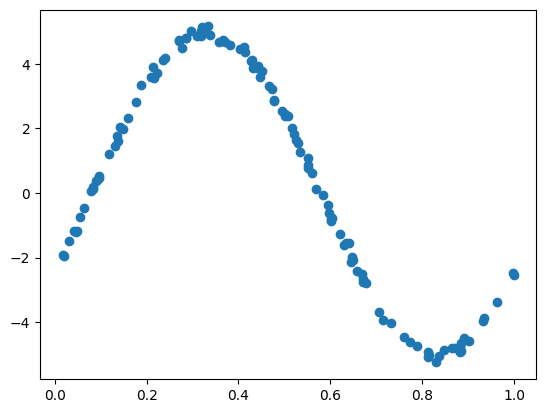

In [7]:
t_folded = t % p
t_index = np.argsort(t_folded)
plt.scatter(t_folded[t_index], y[t_index])

## Clases por tipo de señal

In [8]:
low_signal_length = 70
high_signal_length = 120
n_samples_per_signal = 1000
irregular = True

fun_gen = [random_sin, random_triangular, random_square, random_sawtooth]
times = []
X = []
periods = []
y = []
for i, fun in enumerate(fun_gen):
    for _ in range(n_samples_per_signal):
        t, x, p = fun(random.uniform(0, 5),
                random.uniform(0.1, 1),
                random.uniform(-5, 5),
                0, 
                random.uniform(7., 10.),
                int(random.uniform(low_signal_length, high_signal_length)),irregular=irregular)
        times.append(t)
        X.append(x)
        periods.append(p)
        y.append(i)


## Modelo

In [9]:
from src.layers import Template

import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torchmetrics.classification import MulticlassAccuracy
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

/home/fsoto/miniconda3/envs/el7006/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class SignalDataset(Dataset):
    def __init__(self, X, y, times, periods,mean,std):
        self.X = X
        self.y = y
        self.times = times
        self.periods = periods
        self.mean = mean
        self.std = std
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx],dtype = torch.float32)
        return {'data': (X-self.mean)/self.std,
                'time': torch.tensor(self.times[idx],dtype = torch.float32),
                'mask': torch.ones_like(X)}, torch.tensor(self.y[idx],dtype= torch.long)
    
    def fold(self, idx):
        t = self.times[idx]
        p = self.periods[idx]
        t_folded = t % p
        t_index = np.argsort(t_folded)
        t_folded = t_folded[t_index]
        
        return {'data': (X-self.mean)/self.std,
                'time': torch.tensor(t_folded,dtype = torch.float32),
                'mask': torch.ones_like(X)}, torch.tensor(self.y[idx],dtype= torch.long)


In [11]:
def collate_fn(batch):
    (xx, yy) = zip(*batch)
    x_data = [x['data'] for x in xx]
    x_time = [x['time'] for x in xx]
    x_mask = [x['mask'] for x in xx]

    x_data_pad = pad_sequence(x_data, batch_first=True, padding_value=0)
    x_time_pad = pad_sequence(x_time, batch_first=True, padding_value=0)
    x_mask_pad = pad_sequence(x_mask, batch_first=True, padding_value=0)

    return {'data': x_data_pad.unsqueeze(2), 'time': x_time_pad.unsqueeze(2), 'mask': x_mask_pad.unsqueeze(2)}, torch.stack(yy)

In [12]:
class Model(pl.LightningModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.layer = Template(**kwargs)
                                     
        self.lr = kwargs['lr']

        self.train_acc = MulticlassAccuracy(kwargs['num_classes'], average='micro')
        self.val_acc = MulticlassAccuracy(kwargs['num_classes'], average='micro')

    def forward(self, x):
        return self.layer(**x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        batch_acc = self.train_acc(logits, y)
        self.log('train_acc', batch_acc, prog_bar=True, on_step=True, on_epoch=True)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        batch_acc = self.val_acc(logits, y)
        self.log('val_acc', batch_acc, prog_bar=True, on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [13]:
batch_size = 200
args = {"num_bands": 1,
        "embedding_size": 512,
        "embedding_size_sub": 2048,
        "num_heads": 4,
        "num_encoders": 1,
        "Tmax": 15,
        "num_harmonics": 16,
        "num_classes": 4,
        'lr': 1e-4}

In [14]:
X_train, X_val_test, y_train, y_val_test, times_train, times_val_test, periods_train, periods_val_test= train_test_split(X, y, times,periods, test_size=0.4, random_state=42, stratify=y)

X_val, X_test, y_val, y_test, times_val, times_test, periods_val, periods_test = train_test_split(X_val_test, y_val_test, times_val_test, periods_val_test, test_size=0.5, random_state=42, stratify=y_val_test)


In [15]:
#Calculate mean
count = 0
suma = 0
for x in X_train:
    count += x.shape[0]
    suma += np.sum(x)
mean_train = suma/count
#Calculate std
count = 0
suma = 0
for x in X_train:
    count += x.shape[0]
    suma += np.sum((x-mean_train)**2)
std_train = np.sqrt(suma/count)

In [16]:
train_dataset = SignalDataset(X_train, y_train, times_train, periods_train, mean_train, std_train)
val_dataset = SignalDataset(X_test, y_test, times_test, periods_val, mean_train,std_train)
test_dataset = SignalDataset(X_test, y_test, times_test, periods_test, mean_train,std_train)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=8)

In [17]:
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=200, verbose=True, mode='min')
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min')

In [18]:
trainer = pl.Trainer(max_epochs=2000, gpus=1, callbacks=[checkpoint_callback,early_stop_callback],log_every_n_steps=1)
model = Model(**args)
trainer.fit(model, train_loader, val_loader)

/home/fsoto/miniconda3/envs/el7006/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:479: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  f"Setting `Trainer(gpus={gpus!r})` is deprecated in v1.7 and will be removed"
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fsoto/miniconda3/envs/el7006/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:68: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please

Epoch 0: 100%|██████████| 16/16 [00:01<00:00,  9.14it/s, loss=1.42, v_num=8, train_acc_step=0.265, train_loss_step=1.430, val_acc=0.250, val_loss=1.420]

Metric val_loss improved. New best score: 1.417


Epoch 1: 100%|██████████| 16/16 [00:01<00:00,  8.91it/s, loss=1.41, v_num=8, train_acc_step=0.315, train_loss_step=1.380, val_acc=0.250, val_loss=1.400, train_acc_epoch=0.255, train_loss_epoch=1.420]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 1.397


Epoch 2: 100%|██████████| 16/16 [00:01<00:00,  9.02it/s, loss=1.4, v_num=8, train_acc_step=0.315, train_loss_step=1.380, val_acc=0.251, val_loss=1.390, train_acc_epoch=0.250, train_loss_epoch=1.400] 

Metric val_loss improved by 0.009 >= min_delta = 0.001. New best score: 1.388


Epoch 17: 100%|██████████| 16/16 [00:01<00:00,  8.80it/s, loss=1.35, v_num=8, train_acc_step=0.280, train_loss_step=1.370, val_acc=0.300, val_loss=1.360, train_acc_epoch=0.313, train_loss_epoch=1.360]

Metric val_loss improved by 0.031 >= min_delta = 0.001. New best score: 1.357


Epoch 18: 100%|██████████| 16/16 [00:01<00:00,  8.89it/s, loss=1.31, v_num=8, train_acc_step=0.375, train_loss_step=1.300, val_acc=0.373, val_loss=1.300, train_acc_epoch=0.330, train_loss_epoch=1.340]

Metric val_loss improved by 0.055 >= min_delta = 0.001. New best score: 1.301


Epoch 19: 100%|██████████| 16/16 [00:01<00:00,  8.89it/s, loss=1.28, v_num=8, train_acc_step=0.385, train_loss_step=1.270, val_acc=0.379, val_loss=1.260, train_acc_epoch=0.375, train_loss_epoch=1.300]

Metric val_loss improved by 0.041 >= min_delta = 0.001. New best score: 1.261


Epoch 22: 100%|██████████| 16/16 [00:01<00:00,  8.87it/s, loss=1.24, v_num=8, train_acc_step=0.435, train_loss_step=1.230, val_acc=0.428, val_loss=1.240, train_acc_epoch=0.400, train_loss_epoch=1.250]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.236


Epoch 23: 100%|██████████| 16/16 [00:01<00:00,  8.81it/s, loss=1.23, v_num=8, train_acc_step=0.420, train_loss_step=1.240, val_acc=0.438, val_loss=1.220, train_acc_epoch=0.419, train_loss_epoch=1.240]

Metric val_loss improved by 0.016 >= min_delta = 0.001. New best score: 1.220


Epoch 24: 100%|██████████| 16/16 [00:01<00:00,  8.80it/s, loss=1.21, v_num=8, train_acc_step=0.415, train_loss_step=1.220, val_acc=0.430, val_loss=1.210, train_acc_epoch=0.423, train_loss_epoch=1.230]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.208


Epoch 25: 100%|██████████| 16/16 [00:01<00:00,  8.81it/s, loss=1.21, v_num=8, train_acc_step=0.420, train_loss_step=1.210, val_acc=0.445, val_loss=1.200, train_acc_epoch=0.431, train_loss_epoch=1.210]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 1.197


Epoch 26: 100%|██████████| 16/16 [00:01<00:00,  8.84it/s, loss=1.19, v_num=8, train_acc_step=0.400, train_loss_step=1.230, val_acc=0.460, val_loss=1.180, train_acc_epoch=0.452, train_loss_epoch=1.200]

Metric val_loss improved by 0.021 >= min_delta = 0.001. New best score: 1.177


Epoch 28: 100%|██████████| 16/16 [00:01<00:00,  8.84it/s, loss=1.17, v_num=8, train_acc_step=0.450, train_loss_step=1.200, val_acc=0.486, val_loss=1.140, train_acc_epoch=0.455, train_loss_epoch=1.170]

Metric val_loss improved by 0.036 >= min_delta = 0.001. New best score: 1.141


Epoch 30: 100%|██████████| 16/16 [00:01<00:00,  8.69it/s, loss=1.14, v_num=8, train_acc_step=0.495, train_loss_step=1.120, val_acc=0.471, val_loss=1.130, train_acc_epoch=0.472, train_loss_epoch=1.150]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 1.135


Epoch 31: 100%|██████████| 16/16 [00:01<00:00,  8.87it/s, loss=1.14, v_num=8, train_acc_step=0.465, train_loss_step=1.140, val_acc=0.470, val_loss=1.110, train_acc_epoch=0.473, train_loss_epoch=1.140]

Metric val_loss improved by 0.025 >= min_delta = 0.001. New best score: 1.110


Epoch 34: 100%|██████████| 16/16 [00:01<00:00,  8.80it/s, loss=1.1, v_num=8, train_acc_step=0.465, train_loss_step=1.130, val_acc=0.488, val_loss=1.100, train_acc_epoch=0.495, train_loss_epoch=1.120] 

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.098


Epoch 35: 100%|██████████| 16/16 [00:01<00:00,  8.76it/s, loss=1.1, v_num=8, train_acc_step=0.485, train_loss_step=1.110, val_acc=0.489, val_loss=1.090, train_acc_epoch=0.493, train_loss_epoch=1.100] 

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 1.090


Epoch 38: 100%|██████████| 16/16 [00:01<00:00,  8.78it/s, loss=1.1, v_num=8, train_acc_step=0.500, train_loss_step=1.110, val_acc=0.490, val_loss=1.080, train_acc_epoch=0.502, train_loss_epoch=1.090] 

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 1.077


Epoch 39: 100%|██████████| 16/16 [00:01<00:00,  8.76it/s, loss=1.09, v_num=8, train_acc_step=0.515, train_loss_step=1.080, val_acc=0.490, val_loss=1.070, train_acc_epoch=0.504, train_loss_epoch=1.100]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 1.074


Epoch 41: 100%|██████████| 16/16 [00:01<00:00,  8.85it/s, loss=1.07, v_num=8, train_acc_step=0.540, train_loss_step=1.000, val_acc=0.484, val_loss=1.070, train_acc_epoch=0.498, train_loss_epoch=1.080]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 1.069


Epoch 47: 100%|██████████| 16/16 [00:01<00:00,  8.79it/s, loss=1.06, v_num=8, train_acc_step=0.510, train_loss_step=1.050, val_acc=0.477, val_loss=1.060, train_acc_epoch=0.516, train_loss_epoch=1.060]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.056


Epoch 51: 100%|██████████| 16/16 [00:01<00:00,  8.67it/s, loss=1.04, v_num=8, train_acc_step=0.520, train_loss_step=1.060, val_acc=0.490, val_loss=1.040, train_acc_epoch=0.513, train_loss_epoch=1.040]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 1.043


Epoch 52: 100%|██████████| 16/16 [00:01<00:00,  8.68it/s, loss=1.03, v_num=8, train_acc_step=0.510, train_loss_step=1.070, val_acc=0.501, val_loss=1.030, train_acc_epoch=0.525, train_loss_epoch=1.030]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 1.029


Epoch 53: 100%|██████████| 16/16 [00:01<00:00,  8.71it/s, loss=1.03, v_num=8, train_acc_step=0.495, train_loss_step=1.050, val_acc=0.495, val_loss=1.030, train_acc_epoch=0.518, train_loss_epoch=1.040]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 1.026


Epoch 55: 100%|██████████| 16/16 [00:01<00:00,  8.77it/s, loss=1.03, v_num=8, train_acc_step=0.550, train_loss_step=1.020, val_acc=0.501, val_loss=1.010, train_acc_epoch=0.512, train_loss_epoch=1.030]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.013


Epoch 56: 100%|██████████| 16/16 [00:01<00:00,  8.79it/s, loss=1.01, v_num=8, train_acc_step=0.550, train_loss_step=1.060, val_acc=0.499, val_loss=1.010, train_acc_epoch=0.515, train_loss_epoch=1.020]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 1.012


Epoch 57: 100%|██████████| 16/16 [00:01<00:00,  8.74it/s, loss=1.01, v_num=8, train_acc_step=0.575, train_loss_step=0.936, val_acc=0.507, val_loss=1.000, train_acc_epoch=0.522, train_loss_epoch=1.010]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 1.000


Epoch 58: 100%|██████████| 16/16 [00:01<00:00,  8.76it/s, loss=0.999, v_num=8, train_acc_step=0.575, train_loss_step=0.929, val_acc=0.521, val_loss=0.989, train_acc_epoch=0.522, train_loss_epoch=1.000]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.989


Epoch 59: 100%|██████████| 16/16 [00:01<00:00,  8.74it/s, loss=0.981, v_num=8, train_acc_step=0.535, train_loss_step=0.981, val_acc=0.524, val_loss=0.969, train_acc_epoch=0.539, train_loss_epoch=0.995]

Metric val_loss improved by 0.020 >= min_delta = 0.001. New best score: 0.969


Epoch 60: 100%|██████████| 16/16 [00:01<00:00,  8.82it/s, loss=0.976, v_num=8, train_acc_step=0.485, train_loss_step=1.040, val_acc=0.533, val_loss=0.957, train_acc_epoch=0.530, train_loss_epoch=0.979]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.957


Epoch 62: 100%|██████████| 16/16 [00:01<00:00,  8.84it/s, loss=0.961, v_num=8, train_acc_step=0.585, train_loss_step=0.941, val_acc=0.531, val_loss=0.945, train_acc_epoch=0.547, train_loss_epoch=0.959]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.945


Epoch 63: 100%|██████████| 16/16 [00:01<00:00,  8.72it/s, loss=0.954, v_num=8, train_acc_step=0.585, train_loss_step=0.924, val_acc=0.524, val_loss=0.943, train_acc_epoch=0.562, train_loss_epoch=0.958]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.943


Epoch 64: 100%|██████████| 16/16 [00:01<00:00,  8.80it/s, loss=0.947, v_num=8, train_acc_step=0.560, train_loss_step=0.905, val_acc=0.543, val_loss=0.928, train_acc_epoch=0.559, train_loss_epoch=0.945]

Metric val_loss improved by 0.014 >= min_delta = 0.001. New best score: 0.928


Epoch 66: 100%|██████████| 16/16 [00:01<00:00,  8.60it/s, loss=0.929, v_num=8, train_acc_step=0.525, train_loss_step=0.931, val_acc=0.558, val_loss=0.917, train_acc_epoch=0.563, train_loss_epoch=0.933]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.917


Epoch 68: 100%|██████████| 16/16 [00:01<00:00,  8.67it/s, loss=0.917, v_num=8, train_acc_step=0.565, train_loss_step=0.936, val_acc=0.549, val_loss=0.910, train_acc_epoch=0.555, train_loss_epoch=0.931]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.910


Epoch 69: 100%|██████████| 16/16 [00:01<00:00,  8.83it/s, loss=0.913, v_num=8, train_acc_step=0.620, train_loss_step=0.870, val_acc=0.559, val_loss=0.904, train_acc_epoch=0.576, train_loss_epoch=0.916]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.904


Epoch 70: 100%|██████████| 16/16 [00:01<00:00,  8.61it/s, loss=0.92, v_num=8, train_acc_step=0.590, train_loss_step=0.950, val_acc=0.569, val_loss=0.893, train_acc_epoch=0.558, train_loss_epoch=0.925] 

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.893


Epoch 72: 100%|██████████| 16/16 [00:01<00:00,  8.71it/s, loss=0.91, v_num=8, train_acc_step=0.580, train_loss_step=0.902, val_acc=0.570, val_loss=0.888, train_acc_epoch=0.576, train_loss_epoch=0.901] 

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.888


Epoch 76: 100%|██████████| 16/16 [00:01<00:00,  8.78it/s, loss=0.907, v_num=8, train_acc_step=0.540, train_loss_step=0.946, val_acc=0.575, val_loss=0.884, train_acc_epoch=0.581, train_loss_epoch=0.906]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.884


Epoch 77: 100%|██████████| 16/16 [00:01<00:00,  8.79it/s, loss=0.886, v_num=8, train_acc_step=0.585, train_loss_step=0.910, val_acc=0.551, val_loss=0.876, train_acc_epoch=0.582, train_loss_epoch=0.903]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.876


Epoch 78: 100%|██████████| 16/16 [00:01<00:00,  8.64it/s, loss=0.875, v_num=8, train_acc_step=0.610, train_loss_step=0.860, val_acc=0.586, val_loss=0.869, train_acc_epoch=0.600, train_loss_epoch=0.862]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.869


Epoch 80: 100%|██████████| 16/16 [00:01<00:00,  8.66it/s, loss=0.885, v_num=8, train_acc_step=0.605, train_loss_step=0.877, val_acc=0.594, val_loss=0.863, train_acc_epoch=0.594, train_loss_epoch=0.883]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.863


Epoch 86: 100%|██████████| 16/16 [00:01<00:00,  8.57it/s, loss=0.85, v_num=8, train_acc_step=0.650, train_loss_step=0.777, val_acc=0.594, val_loss=0.855, train_acc_epoch=0.604, train_loss_epoch=0.858] 

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.855


Epoch 92: 100%|██████████| 16/16 [00:01<00:00,  8.54it/s, loss=0.855, v_num=8, train_acc_step=0.520, train_loss_step=0.914, val_acc=0.596, val_loss=0.840, train_acc_epoch=0.602, train_loss_epoch=0.854]

Metric val_loss improved by 0.015 >= min_delta = 0.001. New best score: 0.840


Epoch 94: 100%|██████████| 16/16 [00:01<00:00,  8.68it/s, loss=0.84, v_num=8, train_acc_step=0.665, train_loss_step=0.799, val_acc=0.598, val_loss=0.838, train_acc_epoch=0.617, train_loss_epoch=0.851] 

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.838


Epoch 95: 100%|██████████| 16/16 [00:01<00:00,  8.53it/s, loss=0.831, v_num=8, train_acc_step=0.555, train_loss_step=0.920, val_acc=0.605, val_loss=0.828, train_acc_epoch=0.620, train_loss_epoch=0.828]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.828


Epoch 101: 100%|██████████| 16/16 [00:01<00:00,  8.63it/s, loss=0.83, v_num=8, train_acc_step=0.595, train_loss_step=0.921, val_acc=0.629, val_loss=0.823, train_acc_epoch=0.607, train_loss_epoch=0.836] 

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.823


Epoch 102: 100%|██████████| 16/16 [00:01<00:00,  8.72it/s, loss=0.826, v_num=8, train_acc_step=0.590, train_loss_step=0.799, val_acc=0.606, val_loss=0.815, train_acc_epoch=0.620, train_loss_epoch=0.827]

Metric val_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.815


Epoch 107: 100%|██████████| 16/16 [00:01<00:00,  8.53it/s, loss=0.804, v_num=8, train_acc_step=0.665, train_loss_step=0.849, val_acc=0.623, val_loss=0.812, train_acc_epoch=0.620, train_loss_epoch=0.814]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.812


Epoch 110: 100%|██████████| 16/16 [00:01<00:00,  8.55it/s, loss=0.809, v_num=8, train_acc_step=0.645, train_loss_step=0.795, val_acc=0.621, val_loss=0.808, train_acc_epoch=0.629, train_loss_epoch=0.811]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.808


Epoch 114: 100%|██████████| 16/16 [00:01<00:00,  8.56it/s, loss=0.797, v_num=8, train_acc_step=0.605, train_loss_step=0.790, val_acc=0.624, val_loss=0.804, train_acc_epoch=0.630, train_loss_epoch=0.800]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.804


Epoch 115: 100%|██████████| 16/16 [00:01<00:00,  8.58it/s, loss=0.792, v_num=8, train_acc_step=0.570, train_loss_step=0.881, val_acc=0.616, val_loss=0.797, train_acc_epoch=0.632, train_loss_epoch=0.793]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.797


Epoch 117: 100%|██████████| 16/16 [00:01<00:00,  8.57it/s, loss=0.789, v_num=8, train_acc_step=0.650, train_loss_step=0.771, val_acc=0.619, val_loss=0.793, train_acc_epoch=0.642, train_loss_epoch=0.783]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.793


Epoch 123: 100%|██████████| 16/16 [00:01<00:00,  8.66it/s, loss=0.761, v_num=8, train_acc_step=0.680, train_loss_step=0.700, val_acc=0.623, val_loss=0.792, train_acc_epoch=0.635, train_loss_epoch=0.768]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.792


Epoch 124: 100%|██████████| 16/16 [00:01<00:00,  8.55it/s, loss=0.754, v_num=8, train_acc_step=0.610, train_loss_step=0.807, val_acc=0.631, val_loss=0.782, train_acc_epoch=0.650, train_loss_epoch=0.763]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.782


Epoch 128: 100%|██████████| 16/16 [00:01<00:00,  8.62it/s, loss=0.753, v_num=8, train_acc_step=0.630, train_loss_step=0.793, val_acc=0.627, val_loss=0.777, train_acc_epoch=0.663, train_loss_epoch=0.745]

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.777


Epoch 130: 100%|██████████| 16/16 [00:01<00:00,  8.57it/s, loss=0.761, v_num=8, train_acc_step=0.655, train_loss_step=0.756, val_acc=0.640, val_loss=0.770, train_acc_epoch=0.647, train_loss_epoch=0.758]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.770


Epoch 133: 100%|██████████| 16/16 [00:01<00:00,  8.46it/s, loss=0.741, v_num=8, train_acc_step=0.625, train_loss_step=0.763, val_acc=0.632, val_loss=0.768, train_acc_epoch=0.665, train_loss_epoch=0.743]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.768


Epoch 144: 100%|██████████| 16/16 [00:01<00:00,  8.39it/s, loss=0.724, v_num=8, train_acc_step=0.655, train_loss_step=0.741, val_acc=0.626, val_loss=0.766, train_acc_epoch=0.673, train_loss_epoch=0.734]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.766


Epoch 148: 100%|██████████| 16/16 [00:01<00:00,  8.50it/s, loss=0.72, v_num=8, train_acc_step=0.640, train_loss_step=0.713, val_acc=0.639, val_loss=0.761, train_acc_epoch=0.677, train_loss_epoch=0.721] 

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.761


Epoch 150: 100%|██████████| 16/16 [00:01<00:00,  8.51it/s, loss=0.7, v_num=8, train_acc_step=0.635, train_loss_step=0.765, val_acc=0.644, val_loss=0.751, train_acc_epoch=0.662, train_loss_epoch=0.724]  

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.751


Epoch 157: 100%|██████████| 16/16 [00:01<00:00,  8.52it/s, loss=0.694, v_num=8, train_acc_step=0.680, train_loss_step=0.679, val_acc=0.659, val_loss=0.746, train_acc_epoch=0.671, train_loss_epoch=0.709]

Metric val_loss improved by 0.005 >= min_delta = 0.001. New best score: 0.746


Epoch 158: 100%|██████████| 16/16 [00:01<00:00,  8.42it/s, loss=0.68, v_num=8, train_acc_step=0.680, train_loss_step=0.676, val_acc=0.656, val_loss=0.744, train_acc_epoch=0.681, train_loss_epoch=0.695] 

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.744


Epoch 159: 100%|██████████| 16/16 [00:01<00:00,  8.37it/s, loss=0.674, v_num=8, train_acc_step=0.685, train_loss_step=0.700, val_acc=0.651, val_loss=0.737, train_acc_epoch=0.695, train_loss_epoch=0.668]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.737


Epoch 164: 100%|██████████| 16/16 [00:01<00:00,  8.30it/s, loss=0.674, v_num=8, train_acc_step=0.635, train_loss_step=0.738, val_acc=0.669, val_loss=0.724, train_acc_epoch=0.683, train_loss_epoch=0.677]

Metric val_loss improved by 0.013 >= min_delta = 0.001. New best score: 0.724


Epoch 176: 100%|██████████| 16/16 [00:01<00:00,  8.40it/s, loss=0.648, v_num=8, train_acc_step=0.725, train_loss_step=0.617, val_acc=0.674, val_loss=0.712, train_acc_epoch=0.697, train_loss_epoch=0.654]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.712


Epoch 189: 100%|██████████| 16/16 [00:01<00:00,  8.38it/s, loss=0.628, v_num=8, train_acc_step=0.700, train_loss_step=0.664, val_acc=0.669, val_loss=0.703, train_acc_epoch=0.703, train_loss_epoch=0.628]

Metric val_loss improved by 0.010 >= min_delta = 0.001. New best score: 0.703


Epoch 205: 100%|██████████| 16/16 [00:01<00:00,  8.24it/s, loss=0.59, v_num=8, train_acc_step=0.760, train_loss_step=0.523, val_acc=0.689, val_loss=0.698, train_acc_epoch=0.727, train_loss_epoch=0.612] 

Metric val_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.698


Epoch 216: 100%|██████████| 16/16 [00:01<00:00,  8.22it/s, loss=0.596, v_num=8, train_acc_step=0.725, train_loss_step=0.548, val_acc=0.694, val_loss=0.697, train_acc_epoch=0.734, train_loss_epoch=0.584]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.697


Epoch 416: 100%|██████████| 16/16 [00:02<00:00,  7.74it/s, loss=0.341, v_num=8, train_acc_step=0.855, train_loss_step=0.372, val_acc=0.705, val_loss=0.867, train_acc_epoch=0.853, train_loss_epoch=0.342]

Monitored metric val_loss did not improve in the last 200 records. Best score: 0.697. Signaling Trainer to stop.


Epoch 416: 100%|██████████| 16/16 [00:02<00:00,  7.64it/s, loss=0.341, v_num=8, train_acc_step=0.855, train_loss_step=0.372, val_acc=0.705, val_loss=0.867, train_acc_epoch=0.858, train_loss_epoch=0.339]


In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

## Train metrics

In [20]:
ys_pred_train = []
ys_true_train = []
with torch.no_grad():
    for x, y in train_loader:
        y_hat = model(x)
        ys_pred_train.append(y_hat.softmax(dim=-1).cpu().numpy())
        ys_true_train.append(y.cpu().numpy())
ys_pred_train = np.vstack(ys_pred_train)
ys_true_train = np.hstack(ys_true_train)

In [21]:

print(classification_report(ys_true_train, ys_pred_train.argmax(axis=1), target_names=['sin', 'tri', 'square', 'sawtooth']))

              precision    recall  f1-score   support

         sin       0.81      0.74      0.77       600
         tri       0.77      0.78      0.77       600
      square       0.91      0.95      0.93       600
    sawtooth       0.96      0.98      0.97       600

    accuracy                           0.86      2400
   macro avg       0.86      0.86      0.86      2400
weighted avg       0.86      0.86      0.86      2400



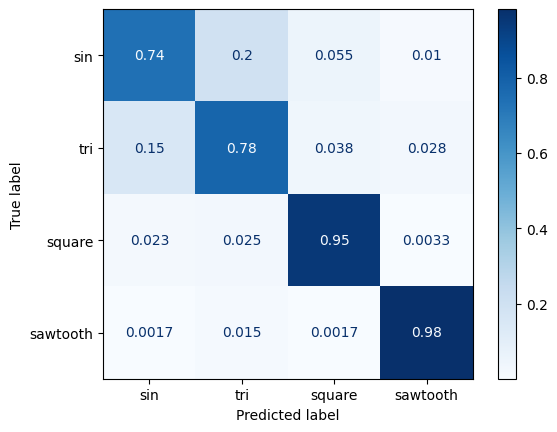

In [22]:
cm = confusion_matrix(ys_true_train, ys_pred_train.argmax(axis=1),normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sin', 'tri', 'square', 'sawtooth'])
disp.plot(cmap=plt.cm.Blues)

classes = ['sin', 'tri', 'square', 'sawtooth']
roc_curves = dict()
for i in range(4):
    fpr, tpr, _ = roc_curve(label_binarize(ys_true_train, classes=[0, 1, 2, 3])[:, i], ys_pred_train[:, i], pos_label=1)
    plt.plot(fpr, tpr, label=f'{classes[i]}')
#0.5 chance
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

## Validation metrics


In [23]:
ys_pred_val = []
ys_true_val = []
with torch.no_grad():
    for x, y in val_loader:
        y_hat = model(x)
        ys_pred_val.append(y_hat.softmax(dim=-1).cpu().numpy())
        ys_true_val.append(y.cpu().numpy())
ys_pred_val = np.vstack(ys_pred_val)
ys_true_val = np.hstack(ys_true_val)


In [24]:
print(classification_report(ys_true_val, ys_pred_val.argmax(axis=1), target_names=['sin', 'tri', 'square', 'sawtooth']))

              precision    recall  f1-score   support

         sin       0.52      0.45      0.48       200
         tri       0.57      0.56      0.56       200
      square       0.76      0.82      0.79       200
    sawtooth       0.90      0.97      0.94       200

    accuracy                           0.70       800
   macro avg       0.69      0.70      0.69       800
weighted avg       0.69      0.70      0.69       800



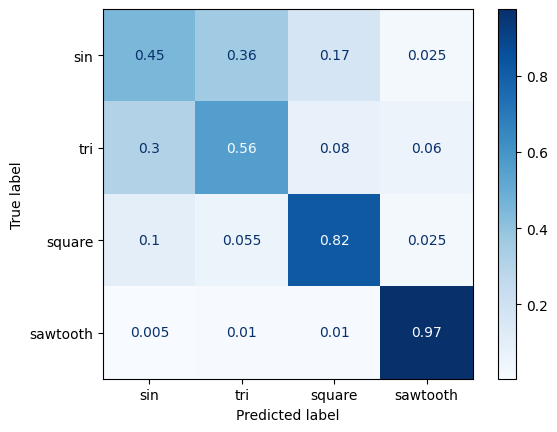

In [25]:
cm = confusion_matrix(ys_true_val, ys_pred_val.argmax(axis=1),normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sin', 'tri', 'square', 'sawtooth'])
disp.plot(cmap=plt.cm.Blues)

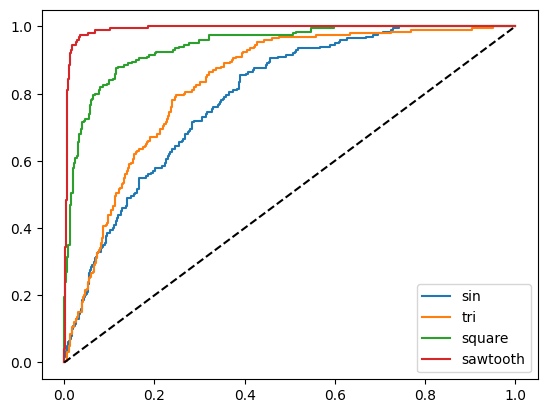

In [26]:
classes = ['sin', 'tri', 'square', 'sawtooth']
roc_curves = dict()
for i in range(4):
    fpr, tpr, _ = roc_curve(label_binarize(ys_true_val, classes=[0, 1, 2, 3])[:, i], ys_pred_val[:, i], pos_label=1)
    plt.plot(fpr, tpr, label=f'{classes[i]}')
#0.5 chance
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()

## Test metrics


In [27]:
ys_pred_test = []
ys_true_test = []
with torch.no_grad():
    for x, y in test_loader:
        y_hat = model(x)
        ys_pred_test.append(y_hat.softmax(dim=-1).cpu().numpy())
        ys_true_test.append(y.cpu().numpy())
ys_pred_test = np.vstack(ys_pred_test)
ys_true_test = np.hstack(ys_true_test)

In [28]:
print(classification_report(ys_true_test, ys_pred_test.argmax(axis=1), target_names=['sin', 'tri', 'square', 'sawtooth']))

              precision    recall  f1-score   support

         sin       0.54      0.47      0.51       200
         tri       0.59      0.60      0.60       200
      square       0.74      0.80      0.77       200
    sawtooth       0.92      0.95      0.94       200

    accuracy                           0.71       800
   macro avg       0.70      0.71      0.70       800
weighted avg       0.70      0.71      0.70       800



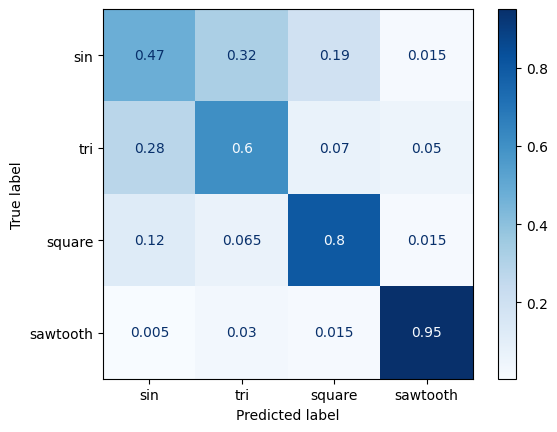

In [29]:
cm = confusion_matrix(ys_true_test, ys_pred_test.argmax(axis=1),normalize ='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['sin', 'tri', 'square', 'sawtooth'])
disp.plot(cmap=plt.cm.Blues)


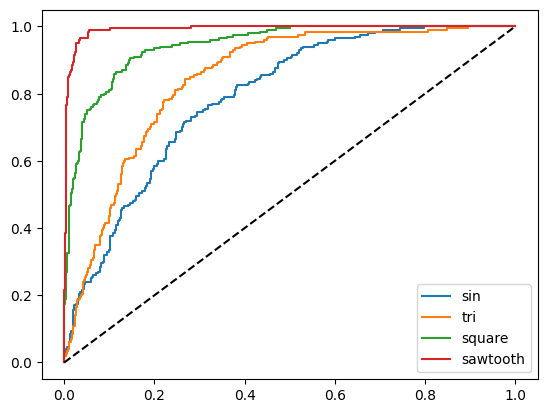

In [30]:
classes = ['sin', 'tri', 'square', 'sawtooth']
roc_curves = dict()
for i in range(4):
    fpr, tpr, _ = roc_curve(label_binarize(ys_true_test, classes=[0, 1, 2, 3])[:, i], ys_pred_test[:, i], pos_label=1)
    plt.plot(fpr, tpr, label=f'{classes[i]}')
#0.5 chance
plt.plot([0, 1], [0, 1], 'k--')
plt.legend()
plt.show()